# A Minimal GAN on MNIST — From Scratch in PyTorch
## Rodolphe Cledassou School 2025

> Marc Huertas-Company & Hubert Bretonnière

This notebook trains a **basic GAN** on MNIST with the discriminator acting as a **binary classifier**:
- **Generator** \(G_\theta(z)\) maps noise \(z\sim\mathcal N(0,I)\) to images.
- **Discriminator** \(D_\psi(x)\in(0,1)\) predicts the probability that an image is **real**.
- **Losses (non‑saturating)**  
  \(\displaystyle \mathcal L_D = \mathrm{BCE}(D(x_{\text{real}}),1)+\mathrm{BCE}(D(G(z)),0)\)  
  \(\displaystyle \mathcal L_G = \mathrm{BCE}(D(G(z)),1)\)

## 1) Setup

In [ ]:
import os, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, utils as vutils
import matplotlib.pyplot as plt

torch.manual_seed(0); np.random.seed(0)
device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

device: cpu


## 2) Hyperparameters

In [2]:
img_size   = 28
img_dim    = 1 * img_size * img_size
z_dim      = 100
g_widths   = [256, 512, 1024]
d_widths   = [512, 256]

batch_size = 128
epochs     = 30
lr         = 2e-4
betas      = (0.5, 0.999)
label_smooth_real = 0.9

sample_every = 1
fixed_z = torch.randn(64, z_dim, device=device)
out_dir = "gan_mnist_outputs"
os.makedirs(out_dir, exist_ok=True)

## 3) Data loading (MNIST)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

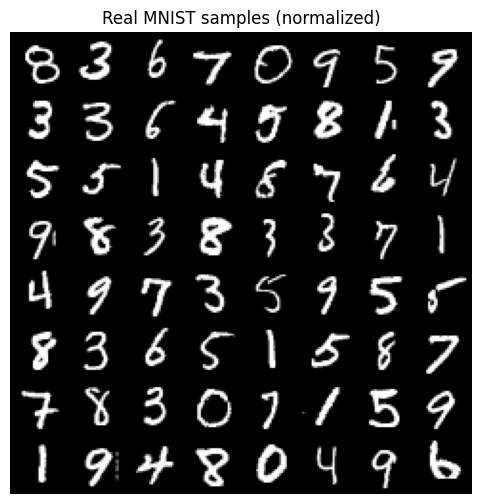

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

real_batch = next(iter(train_loader))[0][:64]
grid = vutils.make_grid(real_batch, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6)); plt.axis("off"); plt.title("Real MNIST samples (normalized)")
plt.imshow(np.transpose(grid.cpu().numpy(), (1,2,0)))
plt.show()

## 4) Models — simple MLP GAN

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim=100, widths=[256,512,1024], out_dim=784):
        super().__init__()
        layers = []
        in_f = z_dim
        for w in widths:
            layers += [nn.Linear(in_f, w), nn.BatchNorm1d(w), nn.ReLU(True)]
            in_f = w
        layers += [nn.Linear(in_f, out_dim), nn.Tanh()]
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        x = self.net(z).view(-1, 1, 28, 28)
        return x

class Discriminator(nn.Module):
    def __init__(self, in_dim=784, widths=[512,256]):
        super().__init__()
        layers = []
        in_f = in_dim
        for w in widths:
            layers += [nn.Linear(in_f, w), nn.LeakyReLU(0.2, inplace=True)]
            in_f = w
        layers += [nn.Linear(in_f, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x).squeeze(-1)

G = Generator(z_dim, g_widths, img_dim).to(device)
D = Discriminator(img_dim, d_widths).to(device)

print(G); print(D)
print("Params G:", sum(p.numel() for p in G.parameters() if p.requires_grad))
print("Params D:", sum(p.numel() for p in D.parameters() if p.requires_grad))

Generator(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)
Params G

## 5) Losses & optimizers (non‑saturating GAN)

In [5]:
bce = nn.BCEWithLogitsLoss()
optG = optim.Adam(G.parameters(), lr=lr, betas=betas)
optD = optim.Adam(D.parameters(), lr=lr, betas=betas)

def d_loss(real_logits, fake_logits, smooth=0.0):
    targets_real = torch.full_like(real_logits, 1.0 - smooth)
    targets_fake = torch.zeros_like(fake_logits)
    return bce(real_logits, targets_real) + bce(fake_logits, targets_fake)

def g_loss(fake_logits):
    targets = torch.ones_like(fake_logits)
    return bce(fake_logits, targets)

## 6) Training loop

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

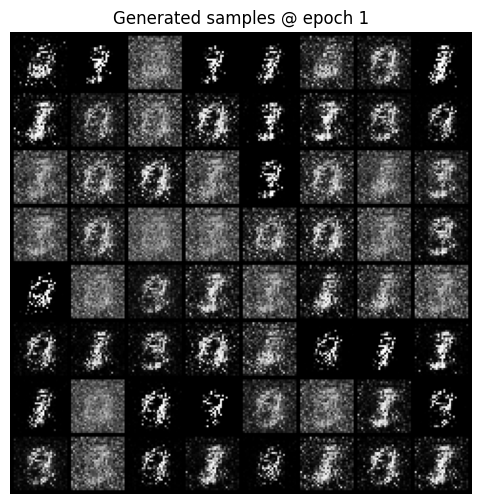

[01/30] D=1.246 G=1.072  (10.8s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

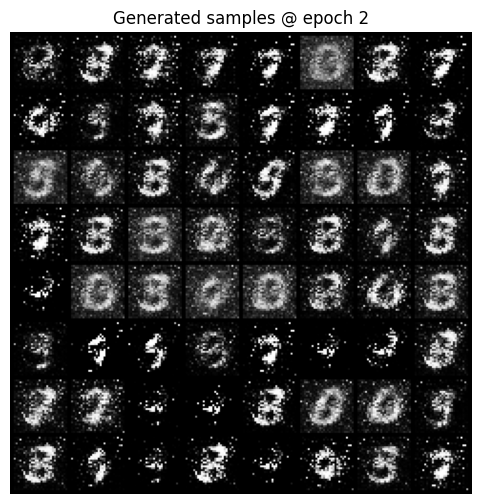

[02/30] D=1.176 G=1.335  (10.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

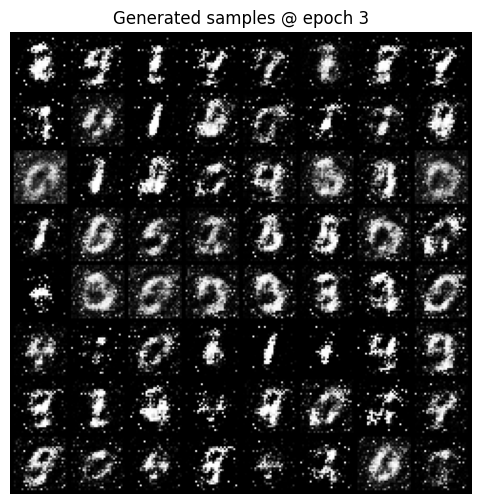

[03/30] D=1.176 G=1.389  (10.1s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

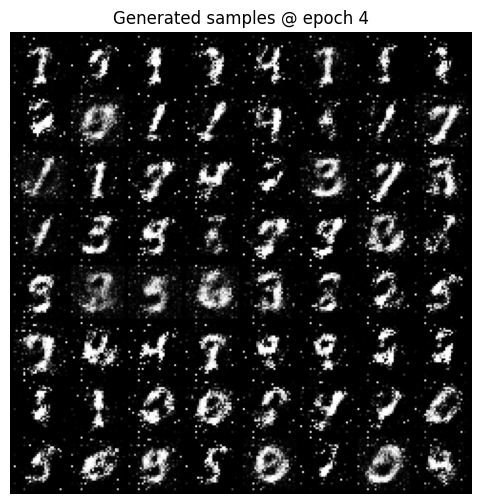

[04/30] D=1.178 G=1.396  (10.7s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

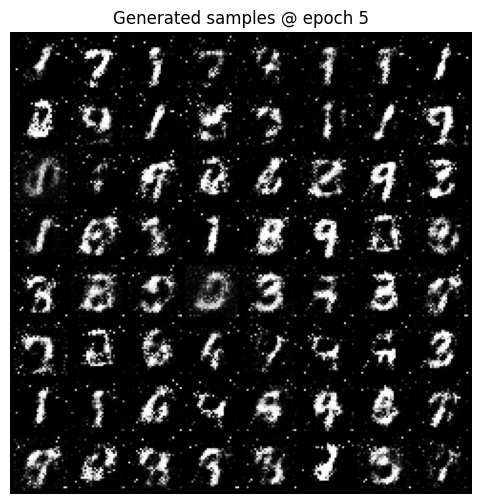

[05/30] D=1.195 G=1.356  (10.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

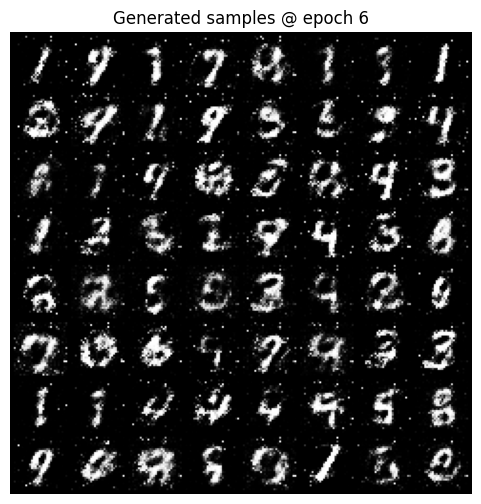

[06/30] D=1.210 G=1.237  (10.7s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

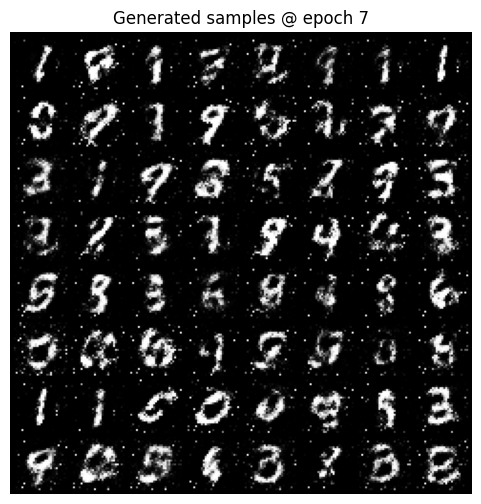

[07/30] D=1.236 G=1.185  (10.8s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

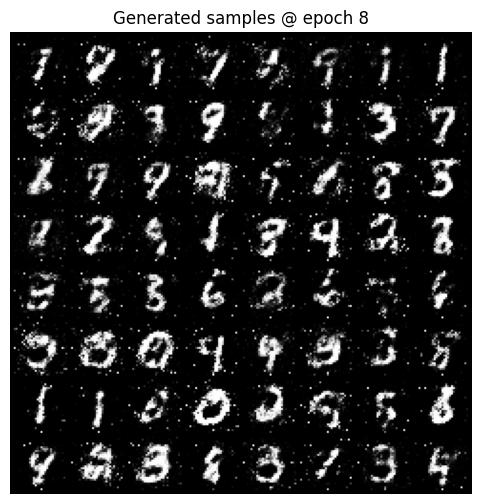

[08/30] D=1.239 G=1.175  (10.8s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

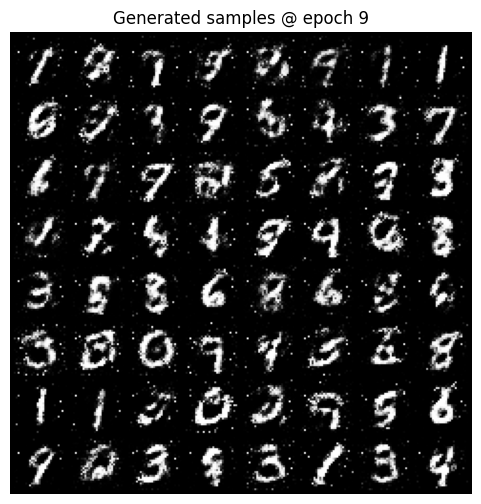

[09/30] D=1.251 G=1.135  (10.4s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

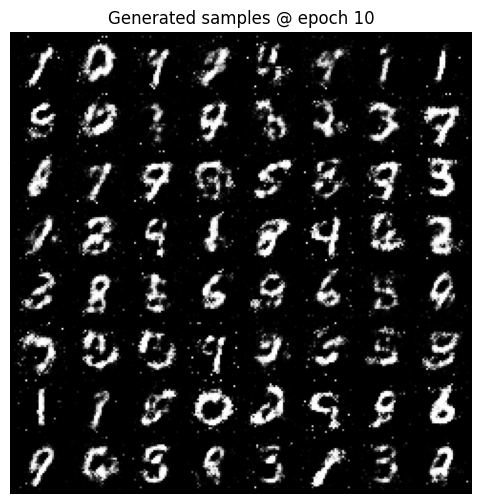

[10/30] D=1.279 G=1.055  (10.1s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

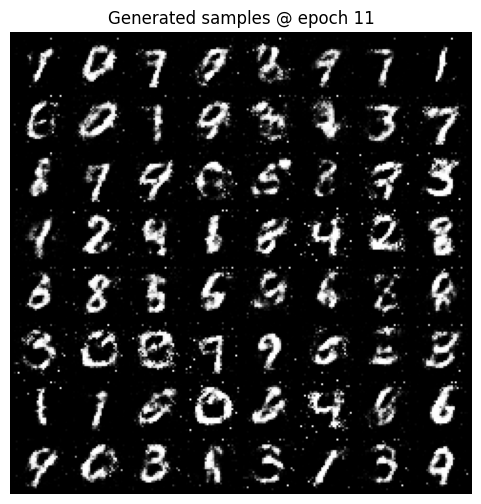

[11/30] D=1.284 G=1.016  (10.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

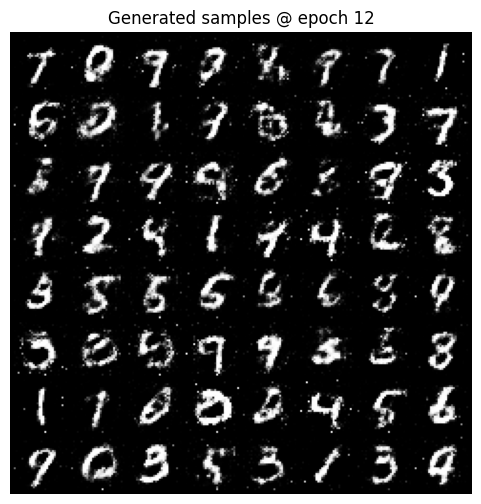

[12/30] D=1.291 G=1.009  (10.5s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

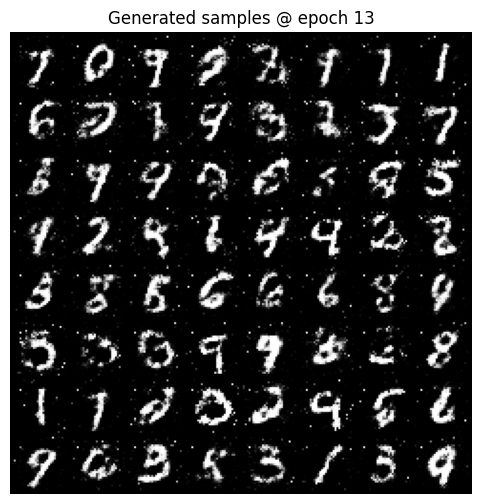

[13/30] D=1.296 G=1.008  (10.9s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

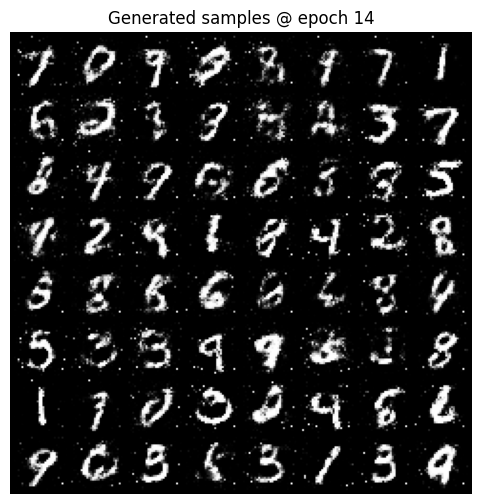

[14/30] D=1.303 G=1.006  (11.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

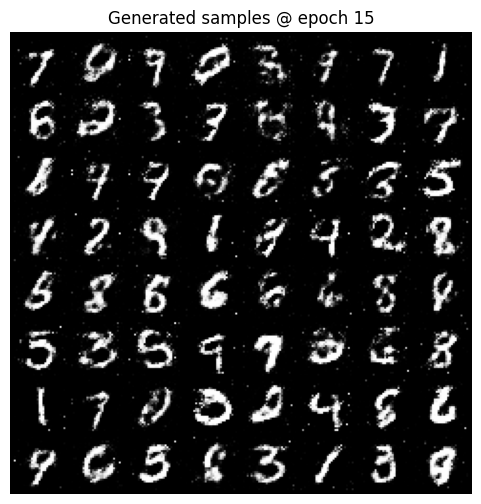

[15/30] D=1.305 G=0.982  (10.6s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

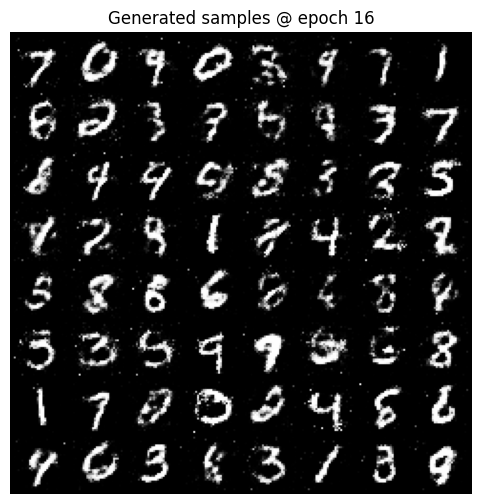

[16/30] D=1.309 G=0.965  (10.4s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

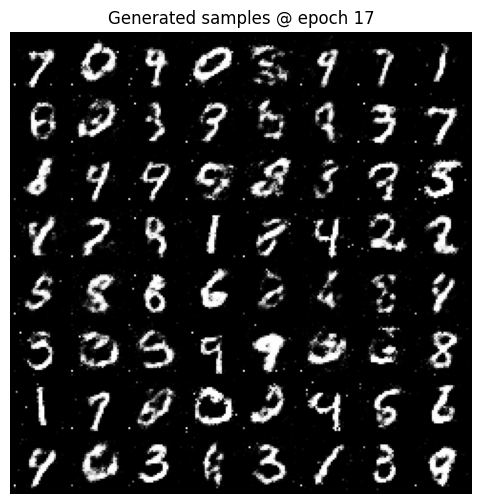

[17/30] D=1.310 G=0.955  (10.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

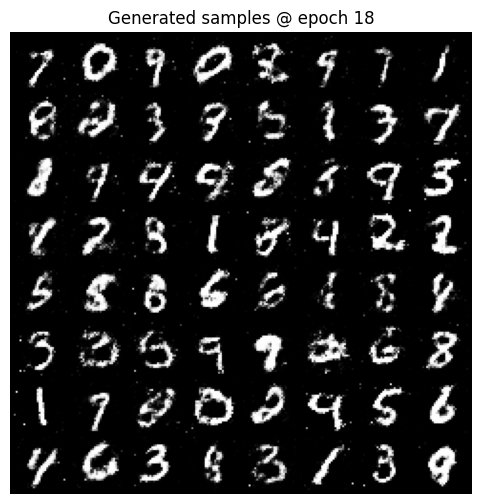

[18/30] D=1.313 G=0.960  (10.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

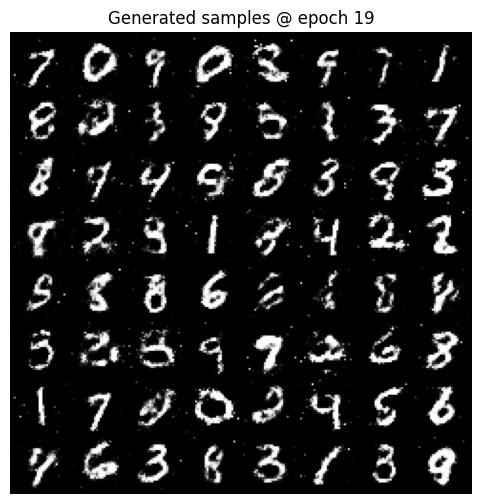

[19/30] D=1.317 G=0.953  (9.9s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

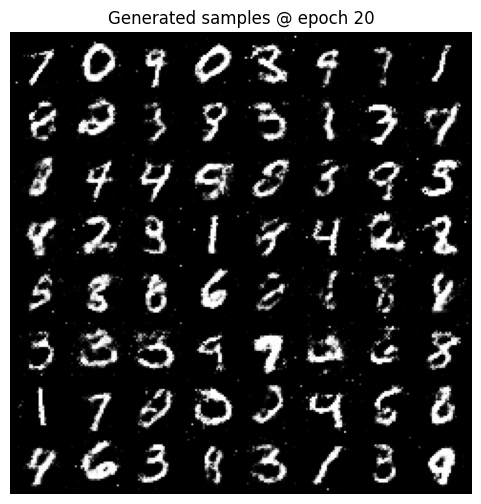

[20/30] D=1.322 G=0.948  (10.1s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

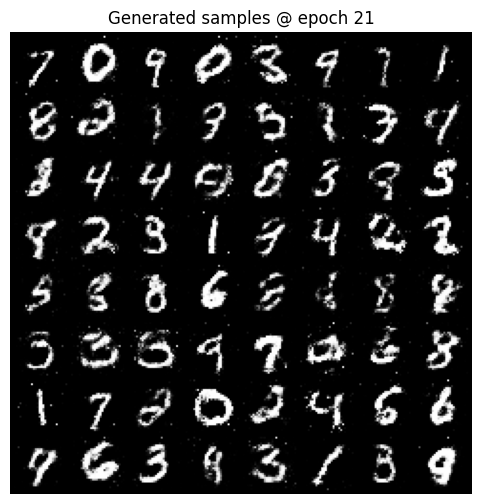

[21/30] D=1.322 G=0.942  (10.2s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

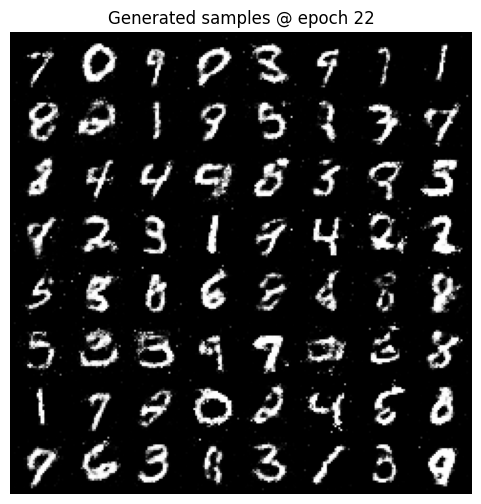

[22/30] D=1.320 G=0.938  (10.4s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

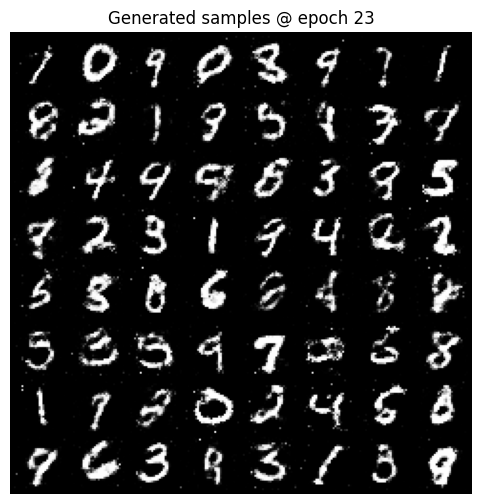

[23/30] D=1.321 G=0.935  (11.4s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

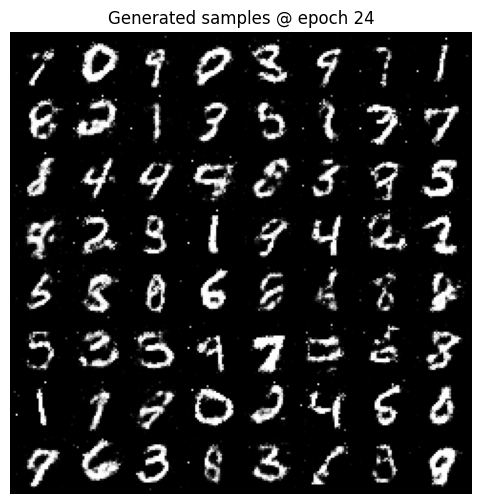

[24/30] D=1.323 G=0.933  (11.3s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

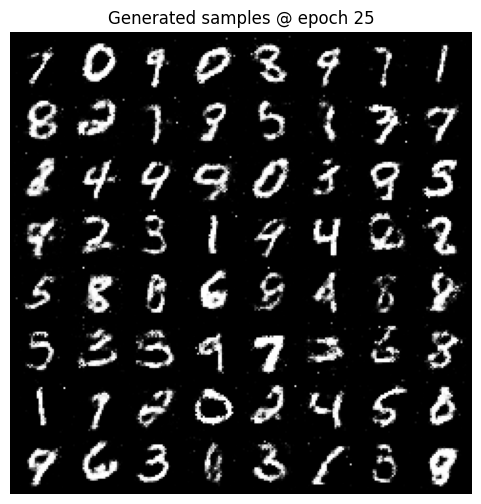

[25/30] D=1.324 G=0.937  (11.0s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

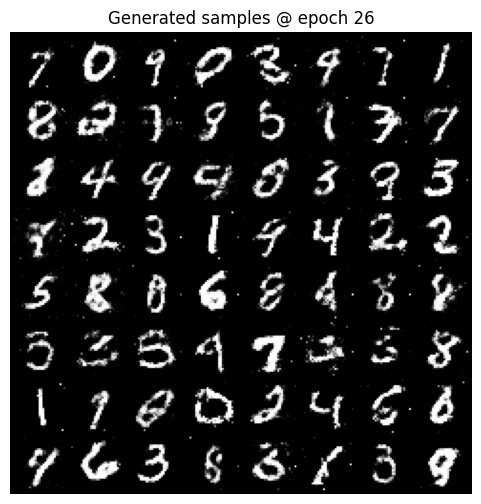

[26/30] D=1.326 G=0.927  (11.0s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

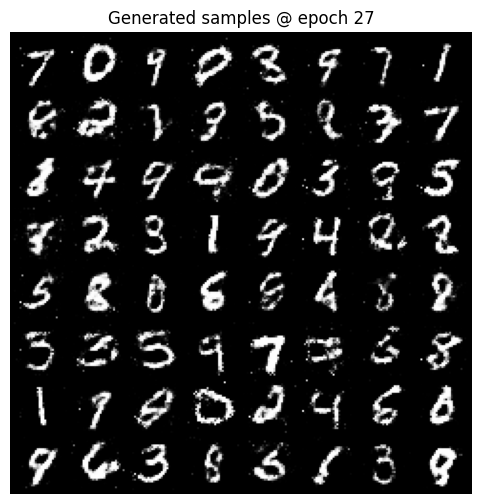

[27/30] D=1.327 G=0.930  (10.5s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

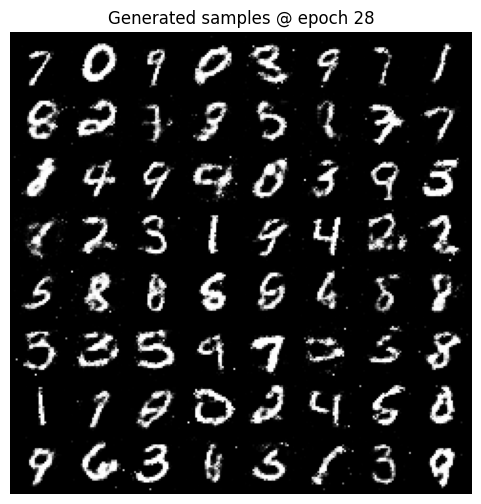

[28/30] D=1.327 G=0.927  (10.4s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

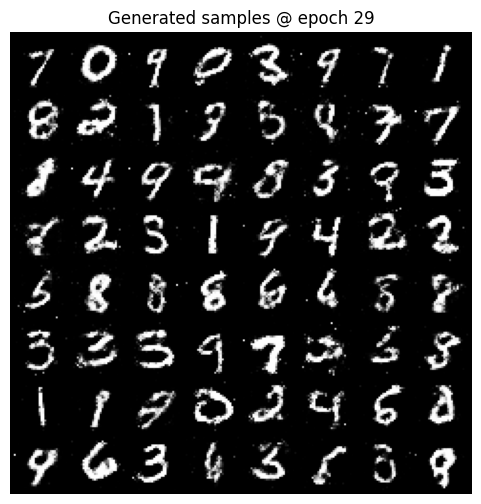

[29/30] D=1.328 G=0.924  (10.5s)


/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/marchuertascompany/soft/miniforge3/envs/spender/bin/../lib/libjpeg.9.dylib' (no su

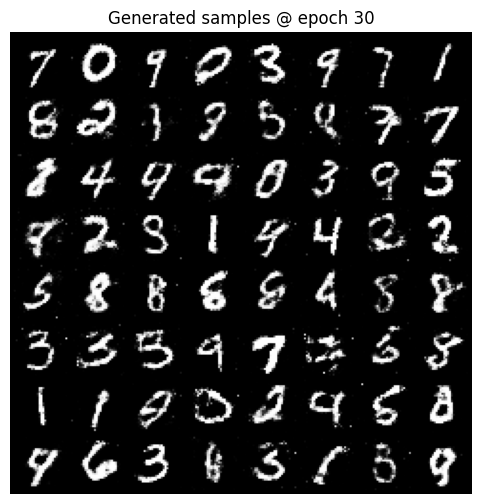

[30/30] D=1.327 G=0.921  (11.1s)


In [6]:
log = {"D": [], "G": []}; step = 0

for ep in range(1, epochs+1):
    t0 = time.time()
    for real, _ in train_loader:
        real = real.to(device, non_blocking=True)
        B = real.size(0)

        # Update D
        z = torch.randn(B, z_dim, device=device)
        fake = G(z).detach()
        logits_real = D(real)
        logits_fake = D(fake)
        loss_D = d_loss(logits_real, logits_fake, smooth=1.0 - label_smooth_real)
        optD.zero_grad(); loss_D.backward(); optD.step()

        # Update G
        z = torch.randn(B, z_dim, device=device)
        fake = G(z)
        logits_fake = D(fake)
        loss_G = g_loss(logits_fake)
        optG.zero_grad(); loss_G.backward(); optG.step()

        log["D"].append(loss_D.item()); log["G"].append(loss_G.item())
        step += 1

    # Sampling
    if ep % sample_every == 0:
        with torch.no_grad():
            fake = G(fixed_z).cpu()
            grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
        plt.figure(figsize=(6,6)); plt.axis("off")
        plt.title(f"Generated samples @ epoch {ep}")
        plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.show()
        vutils.save_image(fake, os.path.join(out_dir, f"samples_epoch_{ep:03d}.png"),
                          nrow=8, normalize=True, value_range=(-1,1))
    print(f"[{ep:02d}/{epochs}] D={np.mean(log['D'][-len(train_loader):]):.3f} "
          f"G={np.mean(log['G'][-len(train_loader):]):.3f}  ({time.time()-t0:.1f}s)")

## 7) Loss curves

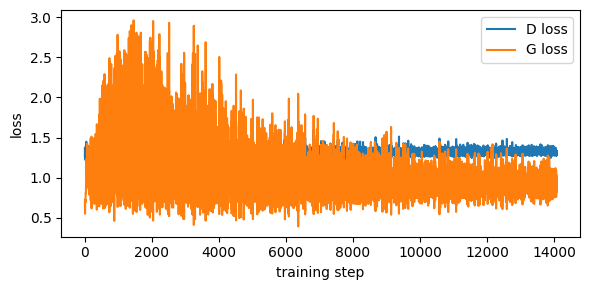

In [7]:
plt.figure(figsize=(6,3))
plt.plot(log["D"], label="D loss")
plt.plot(log["G"], label="G loss")
plt.xlabel("training step"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()

## 8) Final sampling

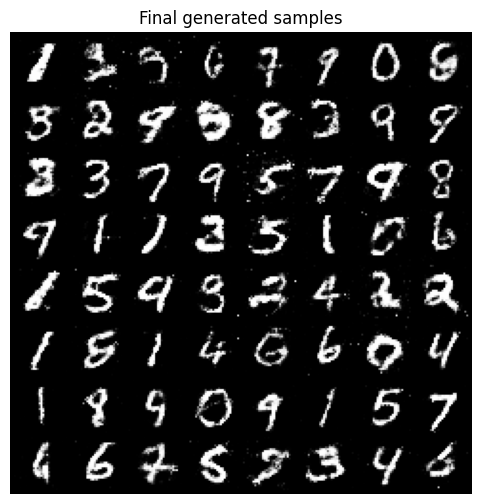

In [8]:
with torch.no_grad():
    z = torch.randn(64, z_dim, device=device)
    fake = G(z).cpu()
grid = vutils.make_grid(fake, nrow=8, normalize=True, value_range=(-1,1))
plt.figure(figsize=(6,6)); plt.axis("off")
plt.title("Final generated samples")
plt.imshow(np.transpose(grid.numpy(), (1,2,0))); plt.show()

## 9) (Optional) Minimax generator loss

To try the original **minimax** generator loss (more prone to saturation), replace `g_loss` with:

```python
def g_loss_minimax(fake_logits):
    # minimize E[ log(1 - D(G(z))) ] using BCE with target 0
    targets = torch.zeros_like(fake_logits)
    return bce(fake_logits, targets)
```